# **INIT NOTEBOOK**



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/reto3

!ls

/content/drive/My Drive/Colab Notebooks/reto3
models	reto3.ipynb  reto3_testX.csv  reto3_trainX.csv	reto3_trainY.csv


In [3]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sb

%matplotlib inline
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA, KernelPCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# **LOAD DATA** and show.

In [4]:
trainset = pd.read_csv('reto3_trainX.csv')
labelset = pd.read_csv('reto3_trainY.csv')
names = trainset.columns

print(trainset.shape)
print(labelset.shape)

(116202, 54)
(116202, 1)


In [ ]:
trainset.head()
#labelset.head()

<BarContainer object of 7 artists>

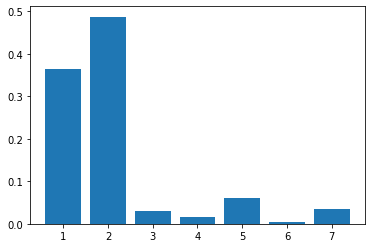

In [13]:
all_dataset = trainset.copy()
all_dataset['tipo_bosque'] = labelset

plt.bar(all_dataset['tipo_bosque'].unique(),all_dataset['tipo_bosque'].value_counts(normalize=True,sort=False))

# **PRE-PROCEADODO**

Separar el dataset en Train y Test.

Normalizacion/escalado de los datos y/o reduccion de dimensiones con PCA.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(trainset, labelset, train_size=0.80, test_size=0.20, random_state=101)

In [6]:
# Elegir MinMaxScaler o StandardScaler en la variable use para aplicar uno de estos escalados.

use = 'MinMaxScaler'
error = False

if use=='MinMaxScaler':
  scaler = MinMaxScaler()
elif use=='StandardScaler':
  scaler = StandardScaler()
else:
  print("Error en el algoritmo elegido.")
  error=True

if error==False:  
  X_train_norm = scaler.fit_transform(X_train)
  X_test_norm = scaler.transform(X_test)
  y_train = y_train.values.ravel()
  y_test = y_test.values.ravel()
  print(X_train_norm.shape)
  print(y_train.shape)


(92961, 54)
(92961,)


In [7]:
# PCA -> reduccion de dimensionalidad a n_components.

n_components = 15 
kernel = "sigmoid" # options are: "linear", "poly", "rbf", "sigmoid"
kernel_parameter = 1

pca = PCA(n_components = n_components)
X_train_proy = pca.fit_transform(X_train_norm)
X_test_proy = pca.transform(X_test_norm)


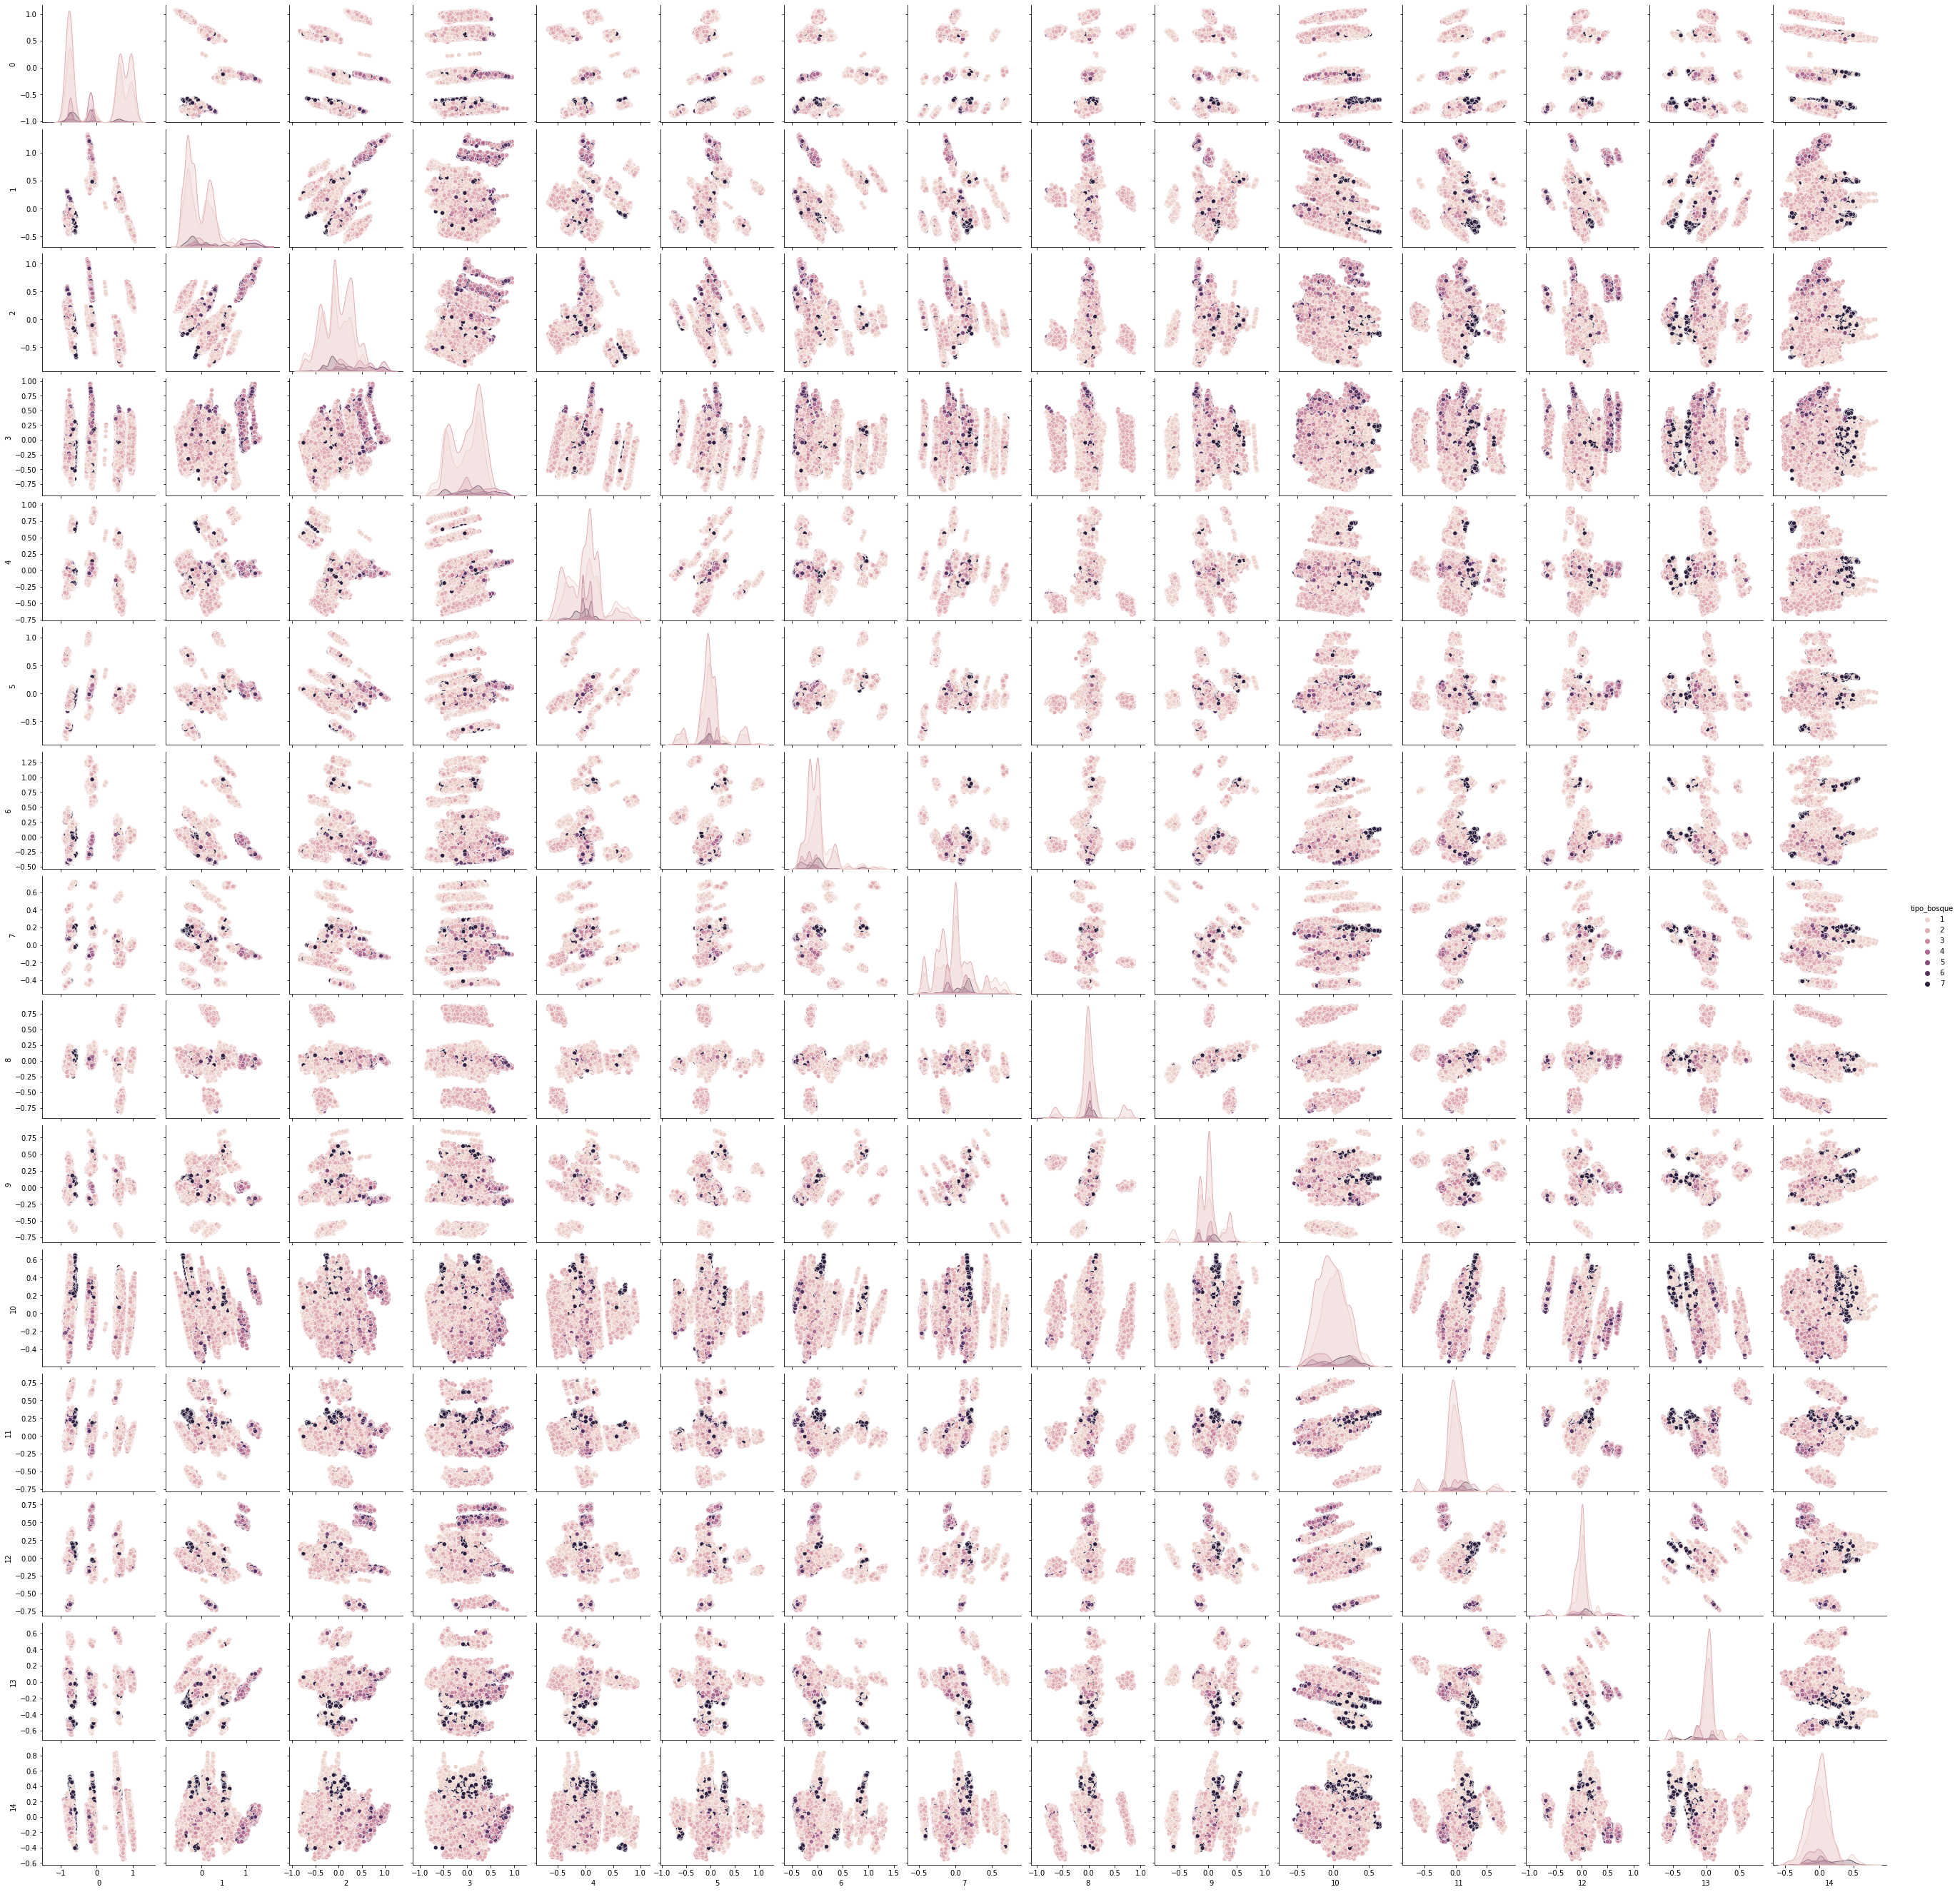

In [16]:
show_proy = pd.DataFrame(X_train_proy)
show_proy['tipo_bosque'] = y_train

sb.pairplot(show_proy, hue='tipo_bosque')

# **RANDOM FOREST**
Busqueda de caracteristitcas con mas relevancia.

In [9]:
# Funcion para entrenar varios RF con diferentes hiperparametros y quedarnos con el mejor.

def TryParamsRF(x_data,y_data,param_grid=None):
  if param_grid==None:
    param_grid = {'n_estimators': [100, 150, 200, 250], 'max_depth': [1, 2], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2']}

  forest = RandomForestClassifier(random_state=0,verbose=0)
  forest_grid = GridSearchCV(forest,param_grid,refit=True,verbose=2)
  forest_grid.fit(x_data,y_data)
  return forest_grid


In [11]:
## Ejecutar celda para entrenar un RF con parametros fijos o probar diferentes configuraciones.

# 0=train con parametros fijos || 1=train con prueba de diferentes parametros.
find_best_model = 0  

if find_best_model==1:
  #param_grid = {'n_estimators': [250], 'max_depth': [2], 'criterion': ['gini'], 'max_features': ['auto']}
  param_grid = {'n_estimators': [100, 150, 200, 250], 'max_depth': [1, 2], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2']}
  forest_grid = TryParamsRF(X_proy,y_train,param_grid=param_grid)
  n_estimators = forest_grid.best_estimator_.n_estimators
  max_depth = forest_grid.best_estimator_.max_depth
  criterion = forest_grid.best_estimator_.criterion
  max_features = forest_grid.best_estimator_.max_features
  print(forest_grid.best_estimator_)

else:
  n_estimators = 200
  max_depth = 12
  criterion = 'gini'
  max_features = 'auto'

forest = RandomForestClassifier(random_state=0,
                                verbose=0,
                                n_estimators=n_estimators,
                                max_depth=max_depth,
                                criterion=criterion,
                                max_features=max_features)

forest.fit(X_train_proy,y_train)
importances = forest.feature_importances_

predictions = forest.predict(X_test_proy)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[ 5638  2740     9     0     0     0    65]
 [ 1079 10173   109     0     6    33     8]
 [    0   148  1275     4     0    44     0]
 [    0     0    60    47     0    10     0]
 [   22   267    11     0    27     0     0]
 [    4   192   216     4     0   281     0]
 [  174    92     0     0     0     0   503]]
              precision    recall  f1-score   support

           1       0.82      0.67      0.73      8452
           2       0.75      0.89      0.81     11408
           3       0.76      0.87      0.81      1471
           4       0.85      0.40      0.55       117
           5       0.82      0.08      0.15       327
           6       0.76      0.40      0.53       697
           7       0.87      0.65      0.75       769

    accuracy                           0.77     23241
   macro avg       0.80      0.57      0.62     23241
weighted avg       0.78      0.77      0.76     23241



Representación de las caracteristicas obtenidas de mas importancia.

Utilizamos un umbral para quedarnos con las relevantes y las guardamos un en nuevo dataset que realizaremos de nuevo el pre-procesador.

In [ ]:
flt = (importances > 0.01)

new_importances = importances[flt]
new_names = names[flt]
trainset_v2 = trainset[new_names].copy()

plt.barh(names[flt], importances[flt])

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(trainset_v2, labelset, train_size=0.80, test_size=0.20, random_state=101)

scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# **SVC**  
#### **(SUPPORT VECTOR MACHINE CLASSIFIER)**

In [ ]:
# Funcion para entrenar varios SVC con diferentes hiperparametros y quedarnos con el mejor.
def TryParamsSVC(x_data, y_data, params_grid=None):

  if params_grid==None:
    param_grid = {'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4, 5], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'sigmoid','poly']}

  model = SVC()
  grid = GridSearchCV(model,param_grid,refit=True,verbose=2)
  grid.fit(X_train,y_train)
  return grid

In [8]:
## Ejecutar celda para entrenar un RF con parametros fijos o probar diferentes configuraciones.

# 0=train con parametros fijos || 1=train con prueba de diferentes parametros.
find_best_model = 0

if find_best_model==1:
  param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.001], 'kernel': ['rbf', 'sigmoid']}
  TryParamsSVC(X_train_norm,y_train,params_grids)
  c = grid.best_estimator_.c
  gamma = grid.best_estimator_.gamma
  kernel = grid.best_estimator_.kernel
  degree = grid.best_estimator_.degree

else: #Manual inputs of parameters.
  c = 0.1
  gamma = 'auto'
  kernel = 'sigmoid'
  degree = 3 #-> Ignored if kernel is not a Poly.

model = SVC(random_state=0, verbose=2, kernel=kernel, C=c, gamma=gamma, degree=degree)
model.fit(X_train_proy,y_train)

predictions = model.predict(X_test_proy)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[LibSVM][[3836 4616    0    0    0    0    0]
 [1665 9611  132    0    0    0    0]
 [   0  585  886    0    0    0    0]
 [   0    0  117    0    0    0    0]
 [  26  301    0    0    0    0    0]
 [   9  324  364    0    0    0    0]
 [ 619  150    0    0    0    0    0]]
              precision    recall  f1-score   support

           1       0.62      0.45      0.53      8452
           2       0.62      0.84      0.71     11408
           3       0.59      0.60      0.60      1471
           4       0.00      0.00      0.00       117
           5       0.00      0.00      0.00       327
           6       0.00      0.00      0.00       697
           7       0.00      0.00      0.00       769

    accuracy                           0.62     23241
   macro avg       0.26      0.27      0.26     23241
weighted avg       0.57      0.62      0.58     23241



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **ADA BOOST CLASSIFIER**

In [12]:
n_estimators = 100
lr = 0.15

ABC = AdaBoostClassifier(n_estimators=n_estimators, random_state=0)
ABC.fit(X_train_proy, y_train)

predictions = ABC.predict(X_test_proy)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[    0  8447     5     0     0     0     0]
 [    0 11276    85    47     0     0     0]
 [    0   585   515   371     0     0     0]
 [    0     1    61    55     0     0     0]
 [    0   327     0     0     0     0     0]
 [    0   335   243   119     0     0     0]
 [    0   769     0     0     0     0     0]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      8452
           2       0.52      0.99      0.68     11408
           3       0.57      0.35      0.43      1471
           4       0.09      0.47      0.16       117
           5       0.00      0.00      0.00       327
           6       0.00      0.00      0.00       697
           7       0.00      0.00      0.00       769

    accuracy                           0.51     23241
   macro avg       0.17      0.26      0.18     23241
weighted avg       0.29      0.51      0.36     23241



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **DECISION TREE CLASSIFIER**

In [9]:
max_depth = 15

DT = DecisionTreeClassifier(random_state=0, max_depth=max_depth)
DT.fit(X_train_proy, y_train)

predictions = DT.predict(X_test_proy)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[6054 2276   10    0   15    4   93]
 [1497 9651  113    1   47   80   19]
 [   1  161 1162   27   12  108    0]
 [   0    1   36   64    0   16    0]
 [  25  197   14    0   91    0    0]
 [  13  122  166    6    4  386    0]
 [ 159   65    0    0    0    0  545]]
              precision    recall  f1-score   support

           1       0.78      0.72      0.75      8452
           2       0.77      0.85      0.81     11408
           3       0.77      0.79      0.78      1471
           4       0.65      0.55      0.60       117
           5       0.54      0.28      0.37       327
           6       0.65      0.55      0.60       697
           7       0.83      0.71      0.76       769

    accuracy                           0.77     23241
   macro avg       0.71      0.63      0.67     23241
weighted avg       0.77      0.77      0.77     23241



# **Gradient Boosting Classifier**

In [ ]:
n_estimators = 100
lr = 0.08

GBC = GradientBoostingClassifier(learning_rate=lr, n_estimators=n_estimators)
GBC.fit(X_train_norm, y_train)

predictions = GBC.predict(X_test_norm)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[6238 2120    4    0    6    3   81]
 [2060 9113  132    0   18   75   10]
 [   0  166 1201   19    0   85    0]
 [   0    0   49   64    0    4    0]
 [   1  260   12    0   54    0    0]
 [   0  173  294    8    0  222    0]
 [ 285    5    0    0    0    0  479]]
              precision    recall  f1-score   support

           1       0.73      0.74      0.73      8452
           2       0.77      0.80      0.78     11408
           3       0.71      0.82      0.76      1471
           4       0.70      0.55      0.62       117
           5       0.69      0.17      0.27       327
           6       0.57      0.32      0.41       697
           7       0.84      0.62      0.72       769

    accuracy                           0.75     23241
   macro avg       0.72      0.57      0.61     23241
weighted avg       0.75      0.75      0.74     23241



# **SAVE MODEL USING PICKLE**

In [ ]:
import pickle
from datetime import datetime

now = datetime.now()
date = now.strftime("%d/%m/_%H:%M:%S")

filename = 'models/SVC_'
path_file = filename+date+'.sav'

pickle.dump(model, open(path_file, 'wb'))